In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')
import seaborn as sns
sns.set_context("paper")
sns.set_style("ticks");

# Autograd with JAX

We do not cover all of JAX's features here, but we do cover the most important ones for our purposes. For a more complete introduction, see the [Advanced Automatic Differentiation in Jax](https://jax.readthedocs.io/en/latest/jax-101/04-advanced-autodiff.html) and the [JAX: Autodiff Cookbook](https://jax.readthedocs.io/en/latest/notebooks/autodiff_cookbook.html) tutorials.
Here we just cover the basics.

In the tutorials above, you can find some trivial examples.
Here let's do something a bit more interesting.
First, take the radial basis functions we made in the {ref}`vectorization` section:

In [2]:
import jax
import jax.numpy as jnp
from jax import jit, vmap, grad
from functools import partial

# This is only vectorized for the centers
@partial(vmap, in_axes=(None, 0, None), out_axes=0)
def rbf_basis(x, c, sigma2):
    return jnp.exp(-jnp.sum((x-c)**2, axis=-1) / sigma2)

Let's let's also make a function that builds the generalized linear model and vectorize with respect to `x`:

In [29]:
@jit
@partial(vmap, in_axes=(0, None, None, None), out_axes=0)
def model(x, w, c, sigma2):
    return jnp.dot(rbf_basis(x, c, sigma2), w).reshape(-1)

Let's draw some random weights and visualize this in 1D:

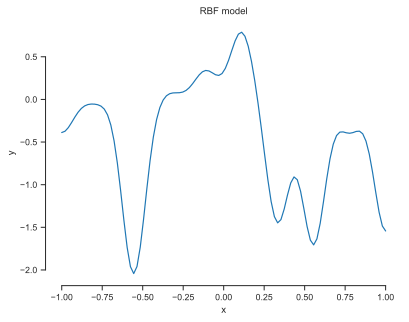

In [30]:
import jax.random as random

sigma2 = 0.01
c = jnp.linspace(-1, 1, 10).reshape(-1, 1)
key = random.PRNGKey(0)
key, subkey = random.split(key)
w = random.normal(subkey, (10,))
x = jnp.linspace(-1, 1, 100).reshape(-1, 1)
y = model(x, w, c, sigma2)

fig, ax = plt.subplots()
ax.plot(x, y, label='model')
ax.set(xlabel='x', ylabel='y', title='RBF model')
sns.despine(trim=True);

Now let's add some data set up a sum of squared errors loss function:

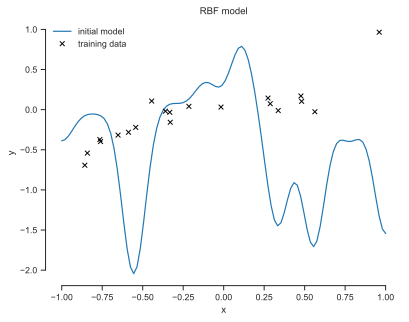

In [34]:
key, subkey = random.split(key)
x_train = random.uniform(subkey, (20, 1), minval=-1, maxval=1)
key, subkey = random.split(key)
y_train = x_train ** 3 + 0.1 * random.normal(subkey, (20,1))

fig, ax = plt.subplots()
ax.plot(x, y, label='initial model')
ax.plot(x_train, y_train, 'kx', label='training data')
ax.set(xlabel='x', ylabel='y', title='RBF model')
plt.legend(loc='best', frameon=False)
sns.despine(trim=True);

The loss function:

In [47]:
def loss(w, c, sigma2, x, y):
    y_pred = model(x, w, c, sigma2)
    return jnp.mean((y - y_pred)**2)

Here is how we can compute the gradient of the loss function with respect to the weights:

In [49]:
loss_grad = jit(grad(loss, argnums=0))

In [50]:
loss_grad(w, c, sigma2, x_train, y_train)

Array([-0.28532007, -0.29728252, -0.19095227, -0.14909464,  0.03849696,
       -0.01216208, -0.4540519 , -0.01067693,  0.04548343, -0.06975526],      dtype=float32)

But we can do more. We can also compute the gradient of the loss function with respect to the the centers and `sigma2`:

In [57]:
full_loss_grad = jit(grad(loss, argnums=(0, 1, 2)))

Here is the result:

In [60]:
w_grad, c_grad, sigma2_grad = full_loss_grad(w, c, sigma2, x_train, y_train)
print(w_grad.shape, c_grad.shape, sigma2_grad.shape)

(10,) (10, 1) ()


We will discuss optimization in a later lecture. Below, is a naive implementation of gradient descent:

In [119]:
import numpy as np

@jit
def gd_step(w, c, sigma2, x, y, lr=0.1):
    w_grad = loss_grad(w, c, sigma2, x, y)
    w = w - lr * w_grad
    return w, c, sigma2

num_iter = 10_000
lr = 0.01
n_batch = 10

w = random.normal(key, (10,))
c = random.uniform(key, (10, 1), minval=-1, maxval=1)
sigma2 = 0.1

for i in range(num_iter):
    w, c, sigma2 = gd_step(w, c, sigma2, x_train, y_train, lr)
    

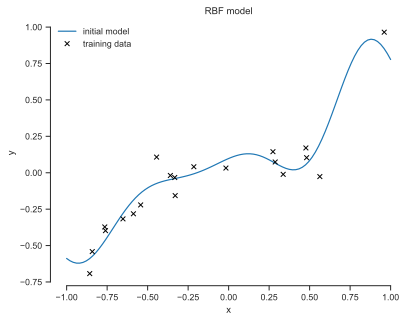

In [121]:
pred = model(x, w, c, sigma2)

fig, ax = plt.subplots()
ax.plot(x, pred, label='initial model')
ax.plot(x_train, y_train, 'kx', label='training data')
ax.set(xlabel='x', ylabel='y', title='RBF model')
plt.legend(loc='best', frameon=False)
sns.despine(trim=True);